In [ ]:
#Challenge 1
#Author: Peter Nguyen
#Purpose: calculate how many gallons of nitrogen were consumed from 2024-10-01 to 2024-12-01

# importing libraries 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Define the tank level data file path
file_path = r"C:\Users\Peter Nguyen\Downloads\TakeHome\n2_tank_level_data.csv"

# Initialize an empty DataFrame for the filtered data
filtered_df = pd.DataFrame()

# handle large datasets by reading in chunks 
for chunk in pd.read_csv(file_path, usecols=['t_stamp_unix', 'tagpath', 'float_value'], chunksize=100000):
    # Convert the Unix timestamp to datetime format
    chunk['timestamp'] = pd.to_datetime(chunk['t_stamp_unix'], unit='ms')
    
    # Filter the data to include only rows within 2024-10-01 00:00:00 to 2024-12-01 00:00:00
    chunk_filtered = chunk[
        (chunk['timestamp'] >= datetime(2024, 10, 1)) &
        (chunk['timestamp'] < datetime(2024, 12, 1))
    ]
    
    # Append the filtered chunk to the main DataFrame
    filtered_df = pd.concat([filtered_df, chunk_filtered], ignore_index=True)

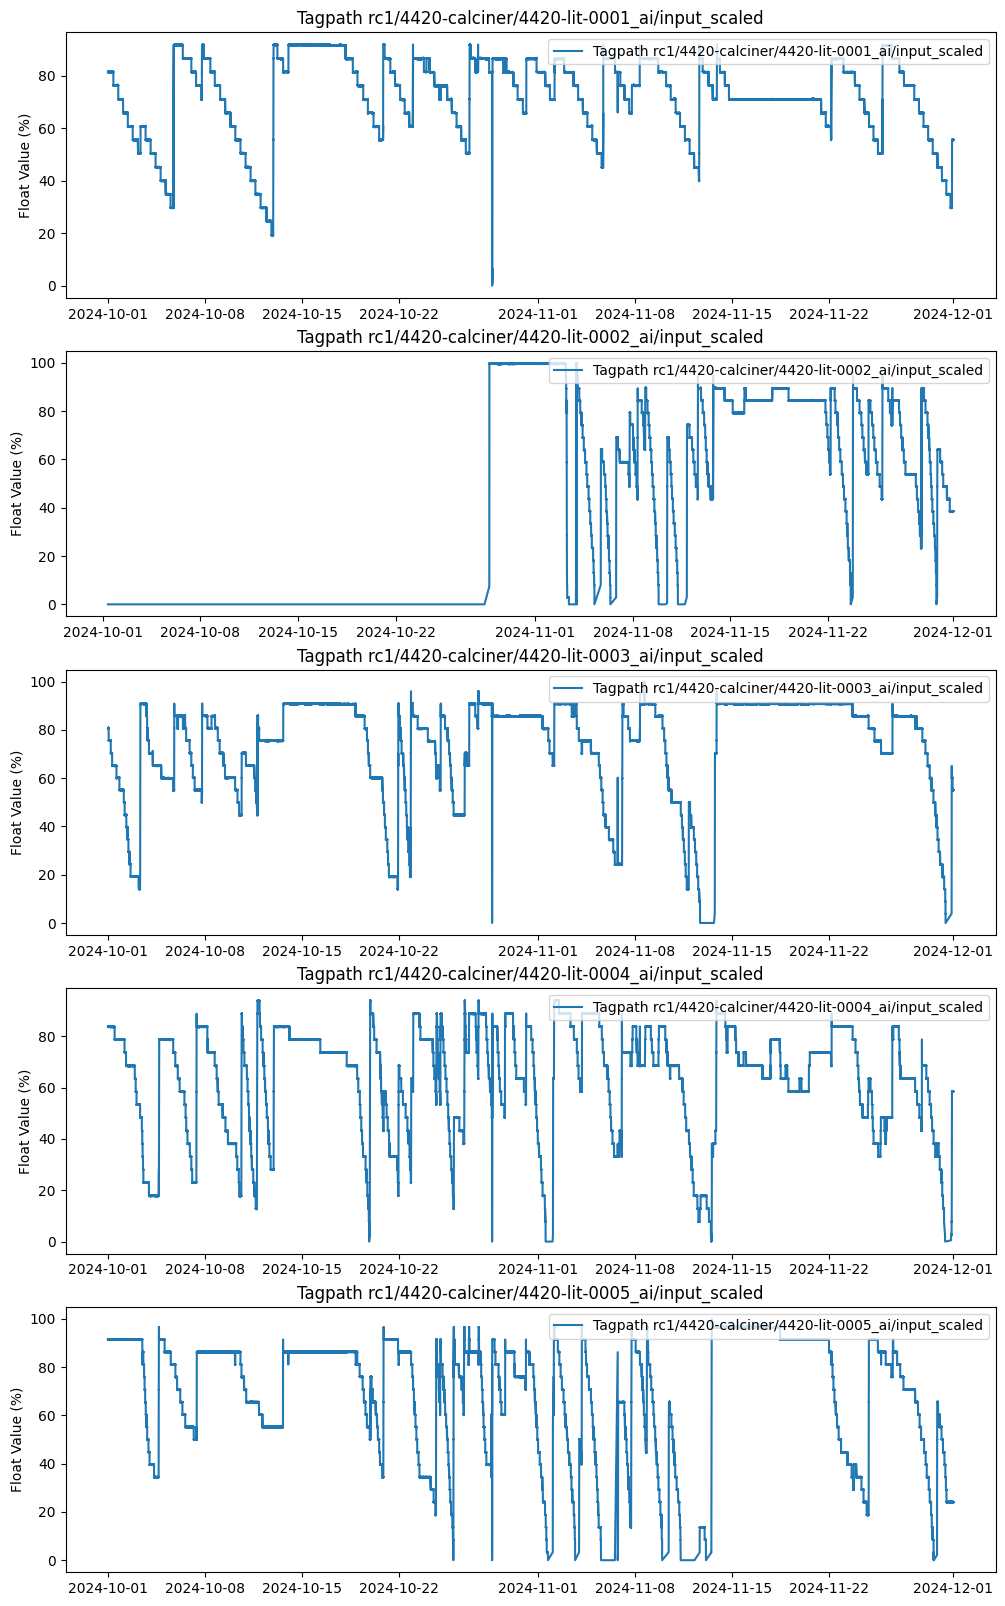

In [57]:
# Sort the data for visualization
filtered_df = filtered_df.sort_values(by=['tagpath', 'timestamp'])

# Plot the data for 5 tagpaths to understand consumption patterns
unique_tagpaths = filtered_df['tagpath'].unique()
fig, ax = plt.subplots(len(unique_tagpaths), 1, figsize=(12, 20))

for i, tagpath in enumerate(unique_tagpaths):
    tagpath_data = filtered_df[filtered_df['tagpath'] == tagpath]
    ax[i].plot(tagpath_data['timestamp'], tagpath_data['float_value'], label=f'Tagpath {tagpath}')
    ax[i].legend(loc="upper right")
    ax[i].set_ylabel('Float Value (%)')
    ax[i].set_title(f'Tagpath {tagpath}')

plt.show()
## The tank level percentage gradually decreases over the course of a pump cycle, indicating consumption, and is then refilled to around 85–90%.

In [ ]:
# Group the filtered data by each tank to calculate consumption
def calculate_consumption(group):
    group = group.sort_values(by='timestamp')
    
    # Calculate the difference between consecutive float values
    group['float_diff'] = group['float_value'].diff()
    
    # Calculate the difference between consecutive timestamps
    group['time_diff'] = group['timestamp'].diff().dt.total_seconds()
    
    # Only consider rows where float value diff is negative (indicating N2 consumption)
    # and time_diff is positive (ensuring chronological order) then sum the float diff 
    consumption = group[(group['float_diff'] < 0) & (group['time_diff'] > 0)]['float_diff'].abs().sum()
    
    # Multiply the percentage difference by 5000 gallons (tank capacity)
    return consumption * 5000

# Apply the calculation to each tank
consumption_per_tank = (
    filtered_df.groupby('tagpath')[['timestamp', 'float_value']]
    .apply(calculate_consumption)
)

# Sum up the consumption across all tanks to get the total nitrogen consumption
total_consumed = consumption_per_tank.sum()
print(f"Total nitrogen consumed: {total_consumed:.0f} gallons")

Total nitrogen consumed: 536874159 gallons
